In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Replace with your path!
!unzip -q "/content/drive/MyDrive/archive.zip" -d data

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
BASE_DIR = '/content/data/UTKFace'

In [5]:
!pip install tqdm
from tqdm import tqdm


In [7]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 270402.32it/s]


In [8]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(10)

,image,age,gender
0,/content/data/UTKFace/24_0_0_20170117150336900...,24,0
1,/content/data/UTKFace/26_0_0_20170113133551354...,26,0
2,/content/data/UTKFace/29_0_1_20170117094430566...,29,0
3,/content/data/UTKFace/38_0_0_20170116211634643...,38,0
4,/content/data/UTKFace/8_1_0_20170109205256828....,8,1
5,/content/data/UTKFace/26_1_3_20170119193117522...,26,1
6,/content/data/UTKFace/22_1_0_20170116214345265...,22,1
7,/content/data/UTKFace/25_0_0_20170116220630282...,25,0
8,/content/data/UTKFace/17_0_0_20170110231711354...,17,0
9,/content/data/UTKFace/26_1_0_20170116231512359...,26,1


In [9]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [10]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

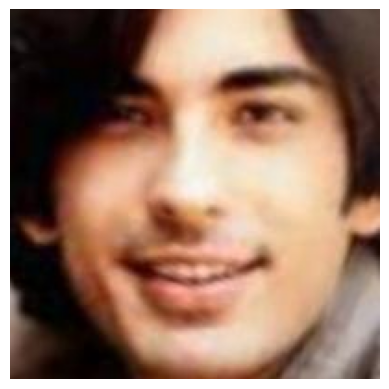

In [11]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

In [12]:
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm
import numpy as np

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image'])

100%|██████████| 23708/23708 [00:33<00:00, 714.69it/s] 


In [13]:
X.shape

# normalize the images
X = X/255.0

In [14]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [15]:
input_shape = (128, 128, 1)

In [16]:
import cv2

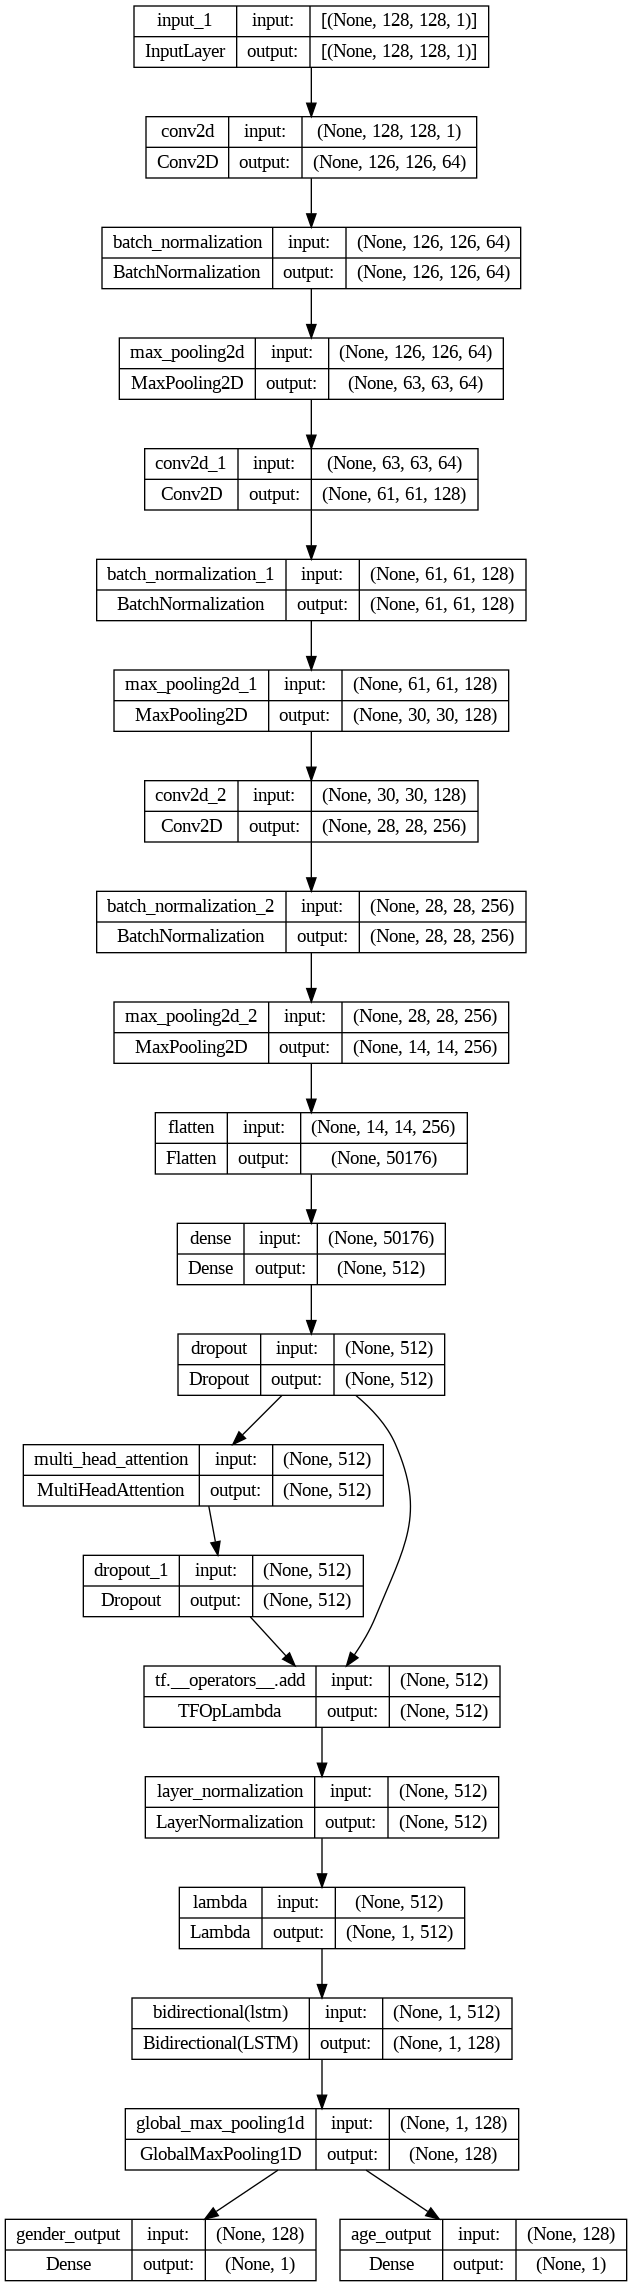

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Bidirectional, LSTM, LayerNormalization, Attention, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, MeanAbsoluteError
from tensorflow.keras.utils import plot_model

X_train, X_val, y_train_gender, y_val_gender, y_train_age, y_val_age = train_test_split(
    X, y_gender, y_age, test_size=0.2, random_state=42)

def create_improved_model(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Transformer Block
    transformer_block = layers.MultiHeadAttention(num_heads=7, key_dim=64, attention_axes=(1,))(x, x, x)  # value and key are the same as query
    transformer_block = layers.Dropout(0.1)(transformer_block)
    transformer_block = layers.LayerNormalization(epsilon=1e-6)(x + transformer_block)

    # Reshape output for BiLSTM Block
    reshaped_block = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(transformer_block)
    bilstm_block = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(reshaped_block)
    bilstm_block = layers.GlobalMaxPooling1D()(bilstm_block)

    # Output Layers
    output_gender = layers.Dense(1, activation='sigmoid', name='gender_output')(bilstm_block)  # Sigmoid for binary classification
    output_age = layers.Dense(1, activation='linear', name='age_output')(bilstm_block)  # Linear activation for regression

    # Create the model
    model = Model(inputs=input_layer, outputs=[output_gender, output_age])

    return model

# Create the updated model
model = create_improved_model(input_shape=(128, 128, 1))

# Define custom metrics for the outputs
metrics = {'gender_output': 'accuracy', 'age_output': 'mae'}

# Compile the model with appropriate loss functions and metrics
model.compile(optimizer=Adam(),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_absolute_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
# Train the model
history = model.fit(x=X_train,
                    y={'gender_output': y_train_gender, 'age_output': y_train_age},
                    batch_size=32,
                    epochs=10 ,
                    validation_data=(X_val, {'gender_output': y_val_gender, 'age_output': y_val_age}))


Epoch 1/10
593/593 [==============================] - 51s 60ms/step - loss: 16.9901 - gender_output_loss: 0.6944 - age_output_loss: 16.2956 - gender_output_accuracy: 0.5082 - age_output_mae: 16.2956 - val_loss: 15.6848 - val_gender_output_loss: 0.6969 - val_age_output_loss: 14.9879 - val_gender_output_accuracy: 0.5120 - val_age_output_mae: 14.9879
Epoch 2/10
593/593 [==============================] - 33s 56ms/step - loss: 14.8472 - gender_output_loss: 0.6738 - age_output_loss: 14.1734 - gender_output_accuracy: 0.5712 - age_output_mae: 14.1734 - val_loss: 11.7666 - val_gender_output_loss: 0.5964 - val_age_output_loss: 11.1703 - val_gender_output_accuracy: 0.7172 - val_age_output_mae: 11.1703
Epoch 3/10
593/593 [==============================] - 33s 56ms/step - loss: 11.0567 - gender_output_loss: 0.6216 - age_output_loss: 10.4351 - gender_output_accuracy: 0.6675 - age_output_mae: 10.4351 - val_loss: 9.3470 - val_gender_output_loss: 0.6189 - val_age_output_loss: 8.7281 - val_gender_output

In [19]:
model.save('/content/drive/MyDrive/new.h5')


In [ ]:
# Evaluate the model
metrics = model.evaluate(X_val, {'gender_output': y_val_gender, 'age_output': y_val_age})

# Extract metrics for gender output
if isinstance(metrics, list):
    gender_loss = metrics[0]
    gender_accuracy = None  # No accuracy available when metrics is a list
else:
    gender_loss = metrics.get
    ('gender_output_loss')
    gender_accuracy = metrics.get('gender_output_accuracy')

# Extract metrics for age output
age_loss = metrics[0] if isinstance(metrics, list) else metrics['age_output_loss']
age_mae = metrics[1] if isinstance(metrics, list) else metrics['age_output_mean_absolute_error']
age_mse = metrics[2] if isinstance(metrics, list) else metrics['age_output_mean_squared_error']

# Calculate total loss explicitly
total_loss = gender_loss + age_loss

# Print the evaluation results
print("Total Loss:", total_loss)
print("Gender Loss:", gender_loss)
print("Age Loss:", age_loss)
print("Gender Accuracy:", gender_accuracy)
print("Age MAE:", age_mae)
print("Age MSE:", age_mse)

149/149 [==============================] - 2s 14ms/step - loss: 7.0003 - gender_output_loss: 0.6088 - age_output_loss: 6.3915 - gender_output_accuracy: 0.6738 - age_output_mae: 6.3915
Total Loss: 14.000529289245605
Gender Loss: 7.000264644622803
Age Loss: 7.000264644622803
Gender Accuracy: None
Age MAE: 0.6087685227394104
Age MSE: 6.391495704650879


Original Gender: Female Original Age: 26
1/1 [==============================] - 0s 36ms/step
Predicted Gender: Female Predicted Age: 26


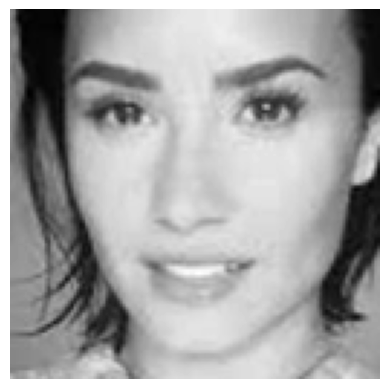

In [ ]:
image_index = 90  # Index of the image to make predictions on

# Print original gender and age labels
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Reshape the image data to match the input shape expected by the model
image = X[image_index].reshape(1, 128, 128, 1)

# Predict using the model
pred = model.predict(image)

# Extract predicted gender and age values
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

# Print predicted gender and age
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)

# Visualize the image
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()


In [ ]:
total_images = X.shape[0]
print("Total number of images in the dataset:", total_images)


Total number of images in the dataset: 23708


In [ ]:
total_images = 2000
mismatch_count = 0

for image_index in range(total_images):
    # Reshape the image data to match the input shape expected by the model
    image = X[image_index].reshape(1, 128, 128, 1)

    # Predict using the model
    pred = model.predict(image)

    # Extract predicted gender value
    pred_gender = gender_dict[round(pred[0][0][0])]

    # Check if the predicted gender is different from the original gender
    if pred_gender != gender_dict[y_gender[image_index]]:
        mismatch_count += 1

gender_accuracy = (total_images - mismatch_count) / total_images
print("Gender accuracy for all images:", gender_accuracy)


1/1 [==============================] - 0s 22ms/step
Gender accuracy for all images: 0.6695


In [ ]:
model.save('model.h5')

In [ ]:
!pip install opencv-python

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_fullbody.xml


--2024-03-29 14:04:00--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_fullbody.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 476827 (466K) [text/plain]
Saving to: ‘haarcascade_fullbody.xml’

haarcascade_fullbod 100%[===================>] 465.65K  --.-KB/s    in 0.004s  

2024-03-29 14:04:00 (119 MB/s) - ‘haarcascade_fullbody.xml’ saved [476827/476827]



In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0   8827      0 --:--:-- --:--:-- --:--:--  8821


In [ ]:
import os

# Start streaming video from webcam
video_stream()

# Label for video
label_html = 'Capturing...'

# Initialize bounding box to empty
bbox = ''

# Initialize variables for face detection and model prediction
detected_face = None
resized_face = None

# Initialize frame counter
frame_counter = 0

while True:
    # Get frame from webcam
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # Initialize bounding box array
    bbox_array = np.zeros([640, 640, 4], dtype=np.uint8)

        # Process each detected face
    for (x, y, w, h) in faces:
        # Modify the bounding box coordinates to cover the entire frame
        x, y, w, h = 0, 0, img.shape[1], img.shape[0]
        detected_face = gray[y:y+h, x:x+w]  # Extract the detected face region
        resized_face = cv2.resize(detected_face, (128, 128)).reshape(1, 128, 128, 1)

        pred = model.predict(resized_face)

        # Extract predicted gender and age values
        pred_gender = gender_dict[round(pred[0][0][0])]
        pred_age = round(pred[1][0][0])

        # Draw bounding box and display predicted gender and age near the bounding box
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(bbox_array, f"Gender: {pred_gender}, Age: {pred_age}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)


    bbox_array[:,:,3] = (bbox_array.max(axis=2) > 0).astype(int) * 255
    # Convert overlay of bbox into bytes
    bbox = bbox_to_bytes(bbox_array)



<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 21ms/step
